## image segmentation - 인물과 배경을 분리

#### 분리된 배경을 blur처리 후, 다시 인물과 합치면 아웃포커싱 효과가 적용된 인물사진을 얻을 수 있다.

1. 배경이 있는 인물사진(배경과 인물의 거리가 멀리 떨어져 있으면 좋다.)

2. Semantic segmentation으로 인물과 배경을 분리

3. blurring_배경을 흐리게

4. 인물을 배경의 원래 위치에 합성

### 인물사진을 이용한 아웃포커싱 적용

In [18]:
# 라이브러리 호출

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


In [19]:
# 라이브러리 호출

import os # 운영체제에서 제공되는 기능(디렉토리 이동, 시스템 환경 변수 호출 등)을 파이썬에서 사용하기 위해
import urllib # 웹에서 데이터를 다운로드할 때

import numpy as np
from pixellib.semantic import semantic_segmentation #semantic_segmantation을 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

(302, 536, 3)


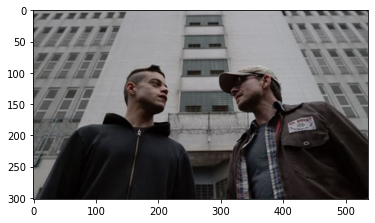

In [40]:
#이미지 불러오기

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/mrRobot01.jpg'
img_orig = cv2.imread(img_path) # 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # 입력이미지의 색상 채널을 변경
plt.show()

In [41]:
# PixelLib에서 제공하는 모델의 다운로드

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'

# os.path.join(a, b) - a, b의 경로를 병합해 새로운 경로model_file을 생성
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# urllib 패키지 내에 있는 request 모듈의 urlretrieve함수를 이용해서 model_url에 있는 파일을 다운로드, model_file 파일명으로 저장
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fc68148d100>)

In [42]:
# 다운로드한 모델을 이용, 사용할 segmentation 모델을 생성

model = semantic_segmentation() # PixelLib 에서 가져온 클래스로 semantic segmentation을 수행하는 클래스 인스턴스를 생성

model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [43]:
# 모델에 이미지를 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

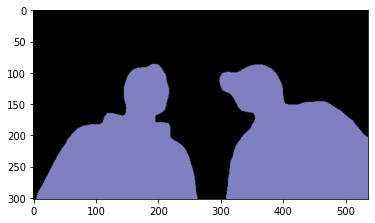

In [44]:
# output 출력

plt.imshow(output)
plt.show()

In [45]:
# 배열값을 출력
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [46]:
# segvalues에 있는 class_ids를 담겨있는 값을 통해 pascalvoc에 담겨있는 라벨을 출력

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [47]:
# 컬러맵 만들기

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap[:20] # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [48]:
# person에 해당하는 15번째 컬러맵 확인

colormap[15]

array([192, 128, 128])

In [49]:
# 색상순서 변경 - colormap의 배열은 RGB, output배열은 BGR순서

seg_color = (128,128,192)

(302, 536)


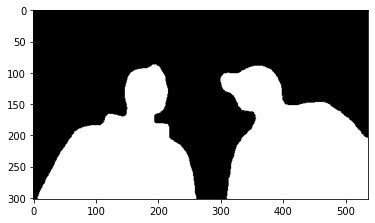

In [50]:
# seg_color로만 이루어진 마스크 생성

seg_map = np.all(output==seg_color, axis=-1) # output의 픽셀 별로 색상이 seg_color와 같다면 1(true), 다르면 0(false)로 출력
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray') # seg_color 값이 person값이므로 사람이 있는 위치를 제외하고 grayscale로 출력
plt.show()

# cmap값을 변경하면 다른 색상으로 확인이 가능

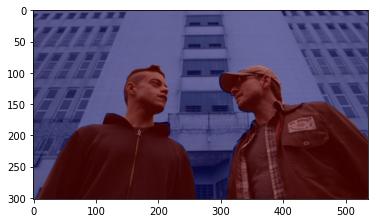

In [51]:
# 원본이미지를 img_show에 할당, 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만들어, 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True와 False인 값을 각각 255와 0으로 변환
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐본다
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

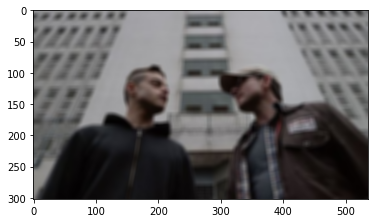

In [56]:
# blur() 함수로 배경을 흐리게

img_orig_blur = cv2.blur(img_orig, (8,8)) # blurring kernel size를 설정

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

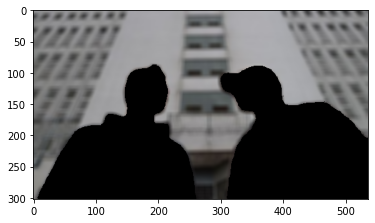

In [57]:
# 흐려진 이미지에서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color) #이미지가 반전. 배경0, 사람255 -> 배경255, 사람0

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

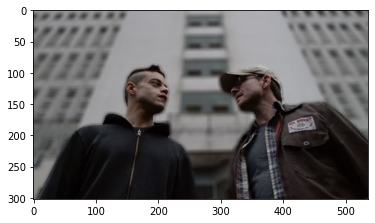

In [58]:
# 흐려진 배경과 인물을 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # segmentation mask가 255인 부분은 원본 이미지, 아닌 영역은 블러

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 크로마키 배경 합성

(495, 742, 3)


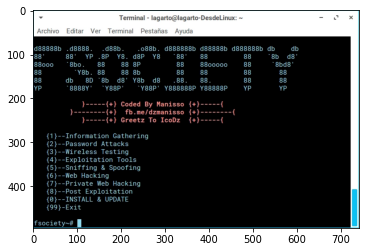

In [59]:
# 합성할 배경이미지 불러오기

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/fsociety01.png'
img_bg_f = cv2.imread(img_path) # 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

print(img_bg_f.shape)

plt.imshow(cv2.cvtColor(img_bg_f, cv2.COLOR_BGR2RGB)) # 입력이미지의 색상 채널을 변경
plt.show()

In [60]:
# 크로마키 배경과 인물을 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_f) # segmentation mask가 255인 부분은 원본 이미지, 아닌 영역은 블러

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: operands could not be broadcast together with shapes (302,536,3) (302,536,3) (495,742,3) 

#### 배경이미지를 단순 합성이 가능할 것이라고 생각했으나 에러 발생.

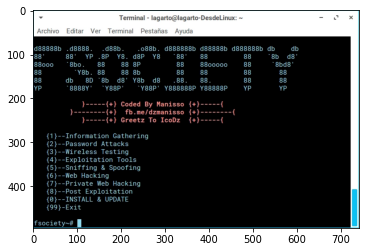

In [64]:
# blur() 함수로 배경을 흐리게

img_orig_blur = cv2.blur(img_bg_f, (1,1)) # blurring kernel size를 설정

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 블러 커널 사이즈를 입력하지 않으면 에러가 발생.

#### 즉 배경을 합성하기 위해서는 블러를 집어넣어야 한다는 결론인데 그럴리가...

### 동물 사진을 이용한 아웃포커싱 적용

(3024, 4032, 3)


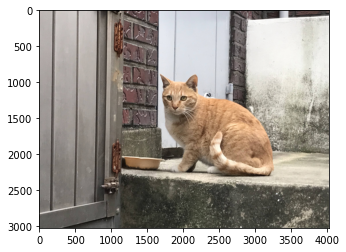

In [21]:
#이미지 불러오기

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat01.jpg'
img_orig = cv2.imread(img_path) # 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # 입력이미지의 색상 채널을 변경
plt.show()

In [22]:
# PixelLib에서 제공하는 모델의 다운로드

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'

# os.path.join(a, b) - a, b의 경로를 병합해 새로운 경로model_file을 생성
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# urllib 패키지 내에 있는 request 모듈의 urlretrieve함수를 이용해서 model_url에 있는 파일을 다운로드, model_file 파일명으로 저장
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fc682fb5f10>)

In [23]:
# 다운로드한 모델을 이용, 사용할 segmentation 모델을 생성

model = semantic_segmentation() # PixelLib 에서 가져온 클래스로 semantic segmentation을 수행하는 클래스 인스턴스를 생성

model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [24]:
# 모델에 이미지를 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

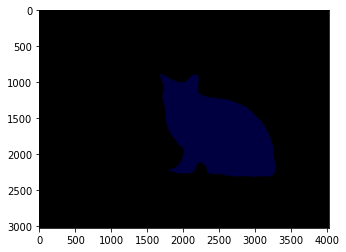

In [25]:
# output 출력

plt.imshow(output)
plt.show()

In [26]:
# 배열값을 출력
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [27]:
# segvalues에 있는 class_ids를 담겨있는 값을 통해 pascalvoc에 담겨있는 라벨을 출력

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [28]:
# 컬러맵 만들기

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap[:20] # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [29]:
# 고양이에 해당하는 8번째 컬러맵 확인

colormap[8]

array([64,  0,  0])

In [30]:
# 색상순서 변경 - colormap의 배열은 RGB, output배열은 BGR순서

seg_color = (0,0,64)

(3024, 4032)


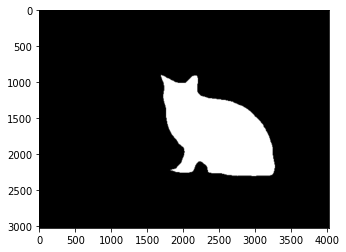

In [31]:
# seg_color로만 이루어진 마스크 생성

seg_map = np.all(output==seg_color, axis=-1) # output의 픽셀 별로 색상이 seg_color와 같다면 1(true), 다르면 0(false)로 출력
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray') # seg_color 값이 person값이므로 사람이 있는 위치를 제외하고 grayscale로 출력
plt.show()

# cmap값을 변경하면 다른 색상으로 확인이 가능

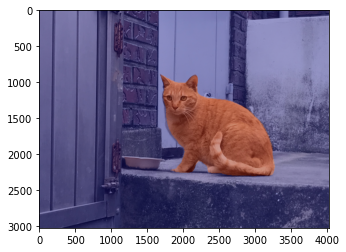

In [32]:
# 원본이미지를 img_show에 할당, 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만들어, 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True와 False인 값을 각각 255와 0으로 변환
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐본다
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

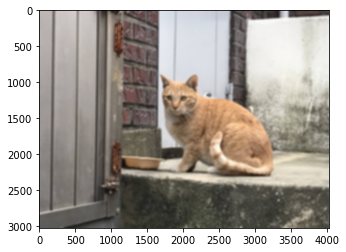

In [37]:
# blur() 함수로 배경을 흐리게

img_orig_blur = cv2.blur(img_orig, (35,35)) # blurring kernel size를 설정

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

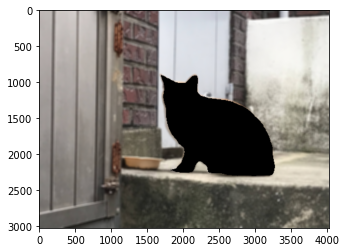

In [38]:
# 흐려진 이미지에서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color) #이미지가 반전. 배경0, 사람255 -> 배경255, 사람0

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

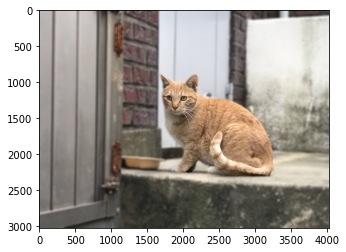

In [39]:
# 흐려진 배경과 고양이를 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # segmentation mask가 255인 부분은 원본 이미지, 아닌 영역은 블러

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 크로마키 배경을 합성하지 못했다.

#### np.where와 bitwise 관련해서 아직 이해가 부족하다.